### Regime Identification in Multivariate Time-series

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import regimes
import numpy as np
import pandas as pd
import seaborn as sns
from clasp import ClaSP
import datasets as dataset
from scipy import stats
from spdms import getSPDMs
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

np.random.seed(1)

In [3]:
# Normalization (Standard)
def normalize(data, type='minmax'):

    if type=='std':
        return (np.array(data) - np.mean(data))/np.std(data)
        
    elif type=='minmax':
        return (np.array(data) - np.min(data))/(np.max(data) - np.min(data))

In [4]:
def difference_dataframe(df, interval=1):
    """
    Applies differencing to all columns of a DataFrame while maintaining timestamps.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with timestamps as index.
        interval (int): The differencing interval. Default is 1.

    Returns:
        pandas.DataFrame: DataFrame with differenced values and timestamps.
    """
    # Extract timestamps if they are set as index
    timestamps = df.index
    
    # Apply differencing to all columns
    diff_df = df.apply(lambda x: np.diff(x, n=interval))
    
    # Restore timestamps to the differenced DataFrame
    diff_df.index = timestamps[1:]  # We lose one timestamp due to differencing
    
    return diff_df


In [5]:
# Function to convert timestamp to formatted date
def convert_timestamp(timestamp):
    # Assuming the timestamp format is 'YYMMDD'
    timestamp = str(timestamp)
    year = int(timestamp[:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])

    # Convert to datetime object
    date_obj = datetime(year, month, day)

    # Format the datetime object as 'DD-Mon-YYYY'
    formatted_date = date_obj.strftime('%d-%b-%Y')

    return formatted_date

In [6]:
def add_date_column(dataframe, starting_date):
    """
    Add a 'date' column to the DataFrame based on the 'day' column and starting date.

    Parameters:
    - dataframe: DataFrame with a 'day' column representing the day of the year.
    - starting_date: Starting date in the format 'DD-MMM-YYYY' (e.g., '01-Jan-2001').

    Returns:
    - DataFrame with the added 'date' column.
    """
    # Number of samples in the data
    num_samples = len(dataframe)

    # Convert the starting date to a datetime object
    start_date = pd.to_datetime(starting_date, format="%d-%b-%Y")

    # Add a new 'date' column based on 'day', 'month', and dynamically assigned 'year'
    dataframe['Date'] = (start_date + pd.to_timedelta(dataframe.index, unit='D')).strftime("%d-%b-%Y")

    return dataframe

In [7]:
# Function to trim time part from date string and use month names abbreviation
def trim_time_and_format(date_string):
    datetime_object = datetime.strptime(date_string, "%d-%b-%Y") # "%Y-%m-%d %H:%M:%S"
    return datetime_object #.strftime("%Y %b")

In [8]:
def generate_multi_regimes_ts(n_variables, n_regimes, series_length, rcps):
    # Set random seed for reproducibility
    np.random.seed(0)
    
    # Generate time index
    time_index = np.arange(series_length)
    
    # Generate regime boundaries
    # rcps = np.linspace(0, series_length, num=n_regimes, endpoint=False)[1:]
    print(rcps)
    
    # Initialize DataFrame with variable names
    variable_names = [f'Var{i+1}' for i in range(n_variables)]
    df = pd.DataFrame(columns=variable_names, index=time_index)
    
    # Define regimes and assign random covariance matrices to each regime
    regimes = []
    for i in range(n_regimes):
        regime_cov_matrix = np.random.rand(n_variables, n_variables)
        regimes.append(regime_cov_matrix @ regime_cov_matrix.T)  # Ensure positive semi-definite
    print(f'Length : {len(regimes)}')
    print(f'Regime boundaries : {len(rcps)}')
    # Generate data for each time point
    for t in range(series_length):
        current_regime = np.sum(t >= rcps)
        # print(f'Current regime : {current_regime}')
        regime_cov_matrix = regimes[current_regime-1]
        
        # Generate random multivariate normal data based on the current regime's covariance matrix
        data_point = np.random.multivariate_normal(mean=np.zeros(n_variables), cov=regime_cov_matrix)
        
        # Assign the data point to the DataFrame
        df.loc[t] = data_point
    
    # Plot the time series with default line colors and styles
    ax = df.plot(figsize=(12, 6), linewidth=1.5)
    
    # Add plot labels and title
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Generated Non-Stationary Time Series')
    
    # Show legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Show grid
    plt.grid(True)
    
    # Display the plot
    plt.tight_layout()
    plt.show()
    
    return df

[  0 500 600]
Length : 3
Regime boundaries : 3


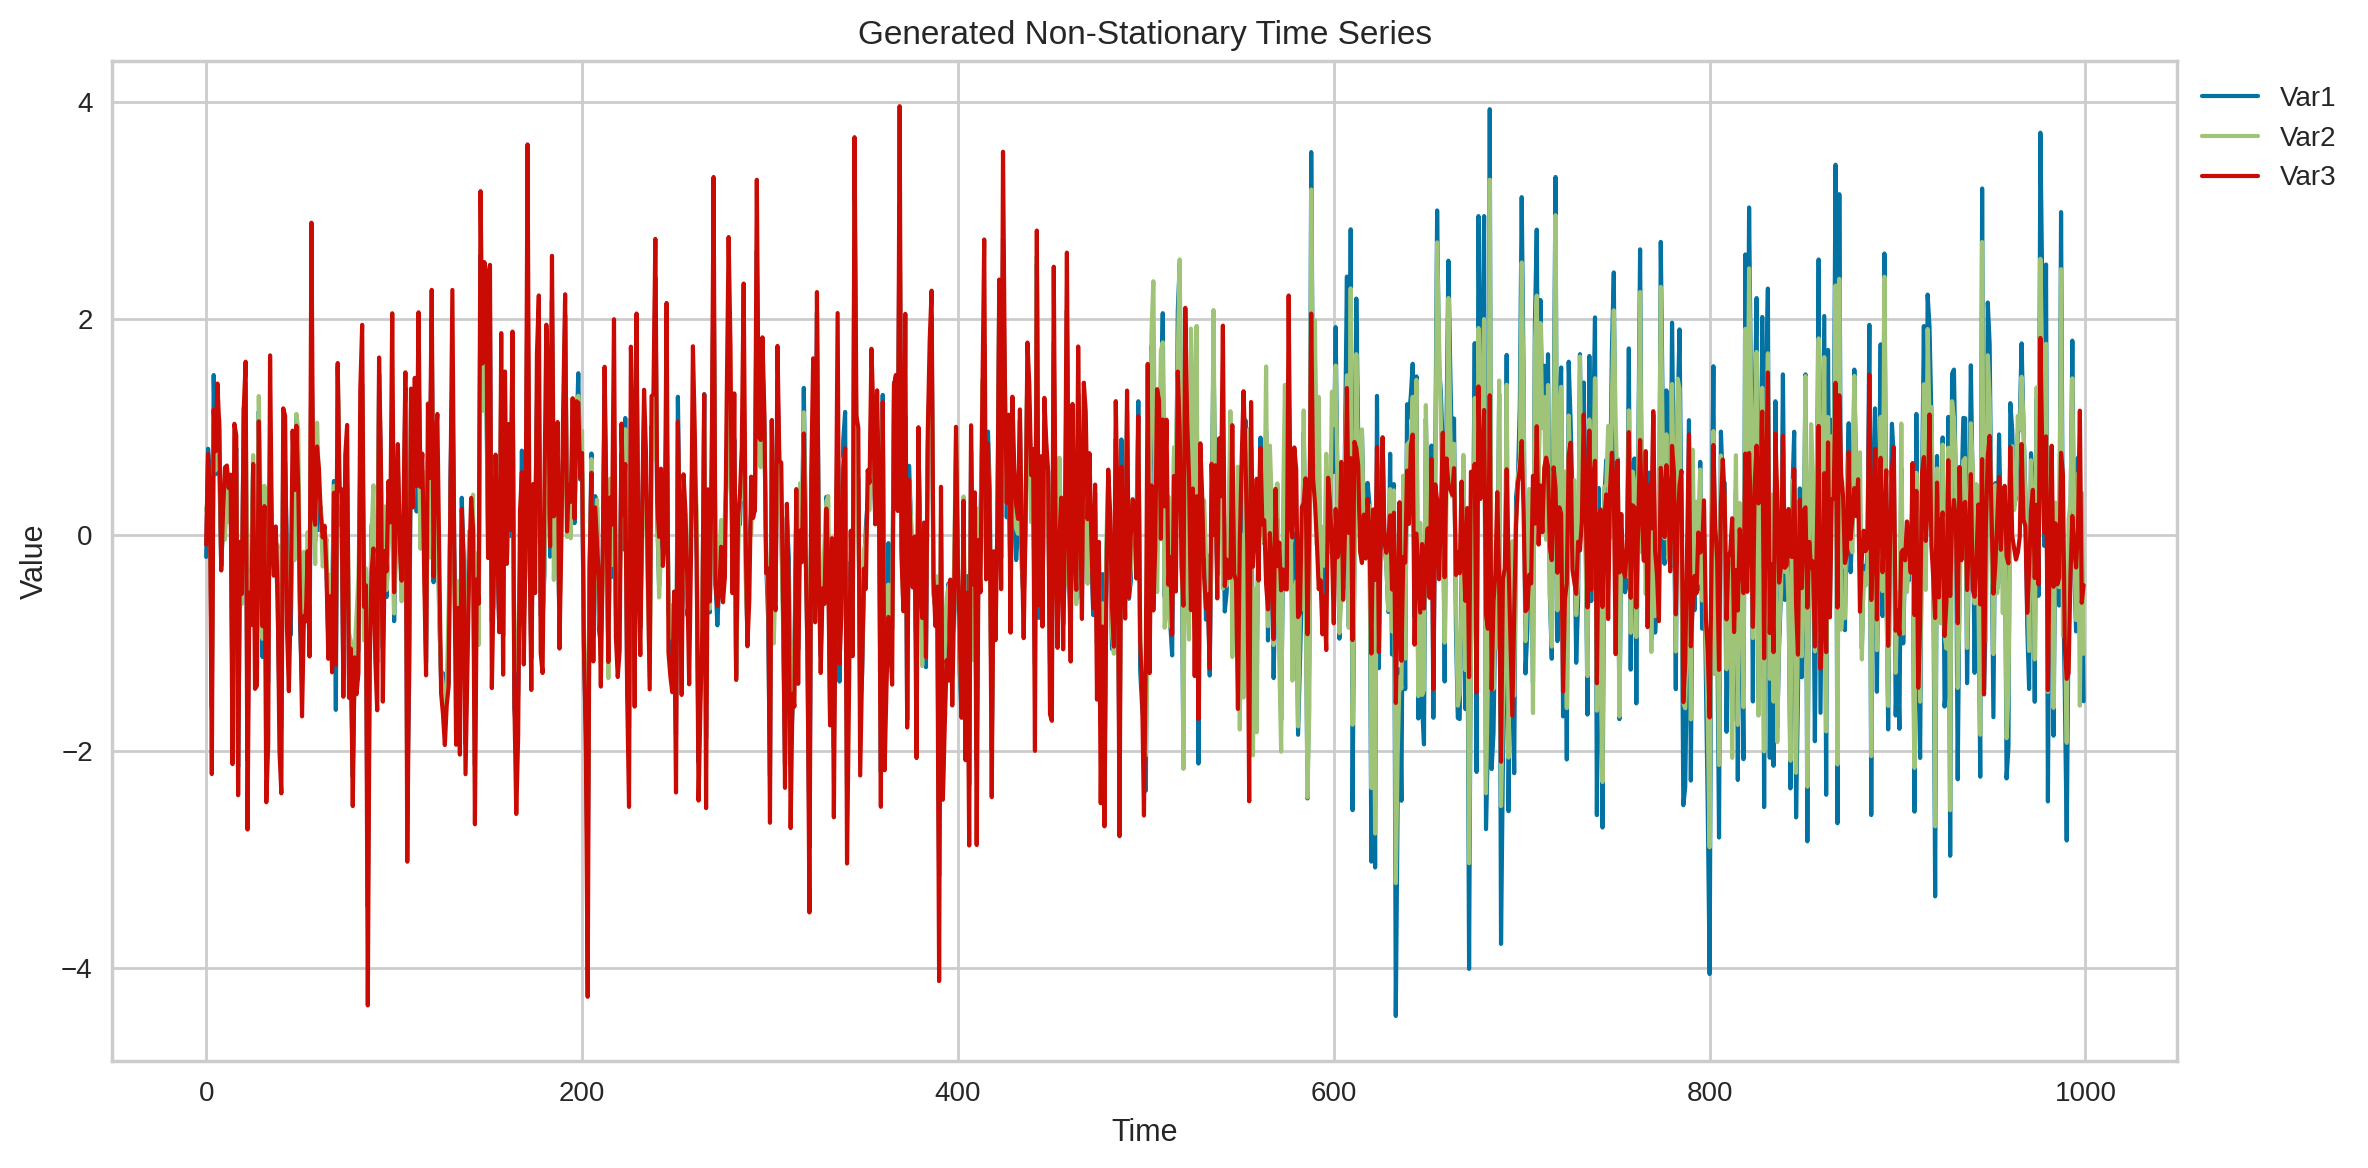

       Var1      Var2      Var3
0 -0.203971  0.228654 -0.088806
1  0.796136  0.349386  0.748005
2  0.555093  0.192164  0.380204
3 -1.596746 -1.323533 -2.210866
4  1.477868  1.103796  1.157048


In [9]:
# Example usage:
n_variables = 3
n_regimes = 3
series_length = 1000
rcps = np.array([0, 500, 600])

# Generate a non-stationary time series DataFrame with plot
data = generate_multi_regimes_ts(n_variables, n_regimes, series_length, rcps)

# Display the DataFrame
print(data.head())

In [10]:
# # Load data
# # file_path = r"/home/ahmad/Projects/gCause/datasets/fluxnet2015/FLX_FR-Pue_FLUXNET2015_SUBSET_2000-2014_2-4/FLX_FR-Pue_FLUXNET2015_SUBSET_DD_2000-2014_2-4.csv"  # Replace with the actual file path
# file_path = r'../datasets/synthetic_datac.csv'
# # file_path = r'/home/ahmad/Projects/RegimeIdentification/'
# data = regimes.read_file(file_path)


In [11]:
# Apply the function to the entire column
time_column_exist, col_name = regimes.find_time_related_columns(data)
print(time_column_exist, col_name)
if time_column_exist:
    data['Date'] = data['Date'].apply(trim_time_and_format)

    start_date = '01-Jan-2002'
    end_date ='31-Dec-2007'
    # fluxnet variables
    # col_list = ['TIMESTAMP', 'SW_IN_F', 'TA_F', 'GPP_NT_VUT_50', 'RECO_NT_VUT_50']
    # Convert the 'date' column to datetime objects
    data[col_name] = data[col_name].apply(convert_timestamp)

    data[col_name] = pd.to_datetime(data[col_name])
    # data = data[(data['TIMESTAMP'] >= start_date) & (data['TIMESTAMP'] <= end_date)][col_list]

    data.set_index(col_name, inplace=True)
    # data = difference_dataframe(data, interval=1)

False []


In [12]:
if len(data.columns)==1:
    data = regimes.shift_and_fill_mean(data, 3)

In [13]:
data.head()

,Var1,Var2,Var3
0,-0.203971,0.228654,-0.088806
1,0.796136,0.349386,0.748005
2,0.555093,0.192164,0.380204
3,-1.596746,-1.323533,-2.210866
4,1.477868,1.103796,1.157048


In [14]:

data = data.fillna(method='pad')
# data = data.set_index('DateTime')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Var1    1000 non-null   float64
 1   Var2    1000 non-null   float64
 2   Var3    1000 non-null   float64
dtypes: float64(3)
memory usage: 63.5 KB


In [15]:
data.isnull().sum()

Var1    0
Var2    0
Var3    0
dtype: int64

In [16]:
# Loop through columns and fill NaN values with mean
for column in data.columns:
    if data[column].isnull().any():
        mean_value = data[column].mean()
        data[column].fillna(mean_value, inplace=True)

In [17]:
# data = data.dropna(how='any',axis=0) 
# data = data.drop(columns=['Date'])
columns = data.columns
data.isnull().sum()

Var1    0
Var2    0
Var3    0
dtype: int64

In [18]:
# toplot = ['Z1', 'Z2','Z5']
# data = data[toplot]
# data.head()

In [19]:
data = data.apply(normalize)

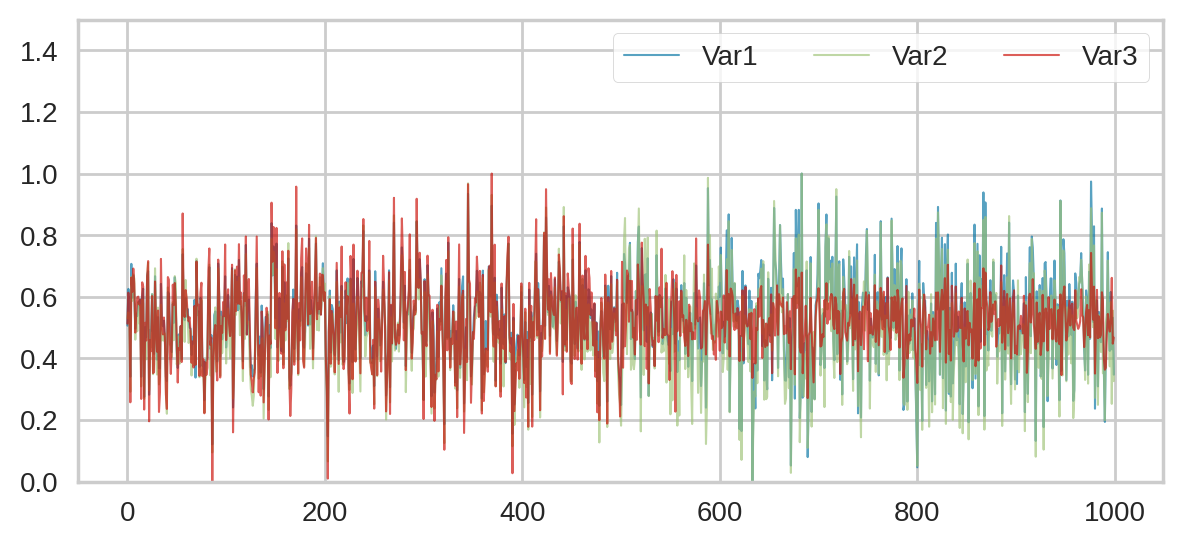

In [20]:
# toplot = [ 'rain', 'snow_load', 'pressure_outside','gw_mb', 'gw_sg', 'gw_west', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = ['Z1', 'Z2','Z5']
toplot = columns

for i in toplot:
    data[i].plot(use_index=True, figsize=(7, 3), linewidth=0.75, alpha=0.66)
    plt.legend(toplot, frameon=True, ncol=3)

plt.ylim(0, 1.5)
# plt.gcf().autofmt_xdate()
# plt.legend(['Temperature', 'Ground Water', 'Strain_EW', 'Strain_NS'])
# plt.legend(['$Z_{1}$', '$Z_{2}$', '$Z_{3}$'])
# plt.savefig("synreg25Apr.png")
plt.show()

In [45]:
# Desired number of clusters. Set k=None to let the algorithm aumotically find opitmal k.
k = None    # k=None

# Sliding window size
winsize = 100 # 155

# distance metrics
metricE = 'Euclidean'
metricR = 'Riemannian'

# Specify reduced dimension size, default is dim='full' for no dimension reduction.
dim = '2' 

# Retrieve regimes with their corresponding indices
clusters, cluster_idx, *_ = regimes.get_regimes(data, winsize, metricR, k, dim)

# Start optimization using solver: trustregion
Optimizing...
                                            f: -3.267893e-01   |grad|: 1.887208e-02
acc TR+   k:     1     num_inner:     1     f: -3.287836e-01   |grad|: 1.458149e-02   exceeded trust region
acc TR+   k:     2     num_inner:     1     f: -3.314781e-01   |grad|: 7.905685e-03   exceeded trust region
REJ TR-   k:     3     num_inner:     2     f: -3.314781e-01   |grad|: 7.905685e-03   negative curvature
acc TR+   k:     4     num_inner:     1     f: -3.319076e-01   |grad|: 1.406489e-04   exceeded trust region
REJ TR-   k:     5     num_inner:     2     f: -3.319076e-01   |grad|: 1.406489e-04   negative curvature
acc TR+   k:     6     num_inner:     2     f: -3.319078e-01   |grad|: 8.408410e-05   negative curvature
acc       k:     7     num_inner:     2     f: -3.319079e-01   |grad|: 2.537004e-05   negative curvature
acc       k:     8     num_inner:     2     f: -3.319079e-01   |grad|: 1.895977e-05   negative curvature
acc   

In [46]:
clusters_extended = []

for i in range(len(clusters)):

    val = clusters[i]
    for j in range(winsize):
        clusters_extended.append(val)
        
        
print(len(clusters_extended), data.shape)

900 (1000, 3)


In [47]:
datanew = data.iloc[:len(clusters_extended), :].copy()
datanew['Clusters'] = clusters_extended

{'Regime 1': 0, 'Regime 2': 100, 'Regime 3': 200, 'Regime 4': 300, 'Regime 5': 400, 'Regime 6': 500, 'Regime 7': 600, 'Regime 8': 700, 'Regime 9': 800}


<Figure size 3000x800 with 0 Axes>

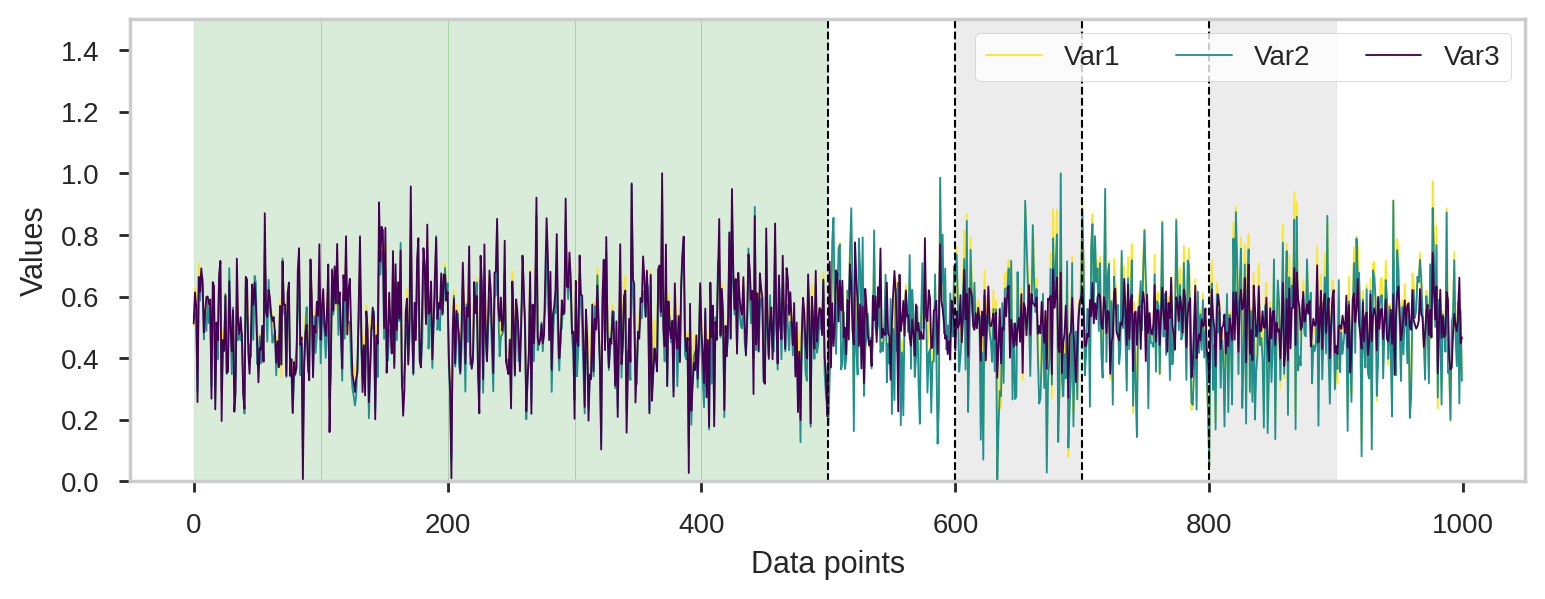

In [48]:
var_to_plot = toplot
regimes.visualize(data, var_to_plot, clusters, cluster_idx, winsize, dtype='real')